In [6]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [7]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)
        
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [16]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    train_mask = torch.BoolTensor(data.train_mask)
    test_mask = torch.BoolTensor(data.test_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, train_mask, test_mask

In [19]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [58]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
dur = []
for epoch in range(50):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/herokuma/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 2.0187 | Test Acc 0.2180 | Time(s) nan
Epoch 00001 | Loss 1.8209 | Test Acc 0.3280 | Time(s) nan
Epoch 00002 | Loss 1.6206 | Test Acc 0.3740 | Time(s) nan
Epoch 00003 | Loss 1.4591 | Test Acc 0.4870 | Time(s) 0.0355
Epoch 00004 | Loss 1.3291 | Test Acc 0.5230 | Time(s) 0.0362
Epoch 00005 | Loss 1.2170 | Test Acc 0.5710 | Time(s) 0.0372
Epoch 00006 | Loss 1.1236 | Test Acc 0.6030 | Time(s) 0.0365
Epoch 00007 | Loss 1.0442 | Test Acc 0.6220 | Time(s) 0.0368
Epoch 00008 | Loss 0.9734 | Test Acc 0.6400 | Time(s) 0.0369
Epoch 00009 | Loss 0.9095 | Test Acc 0.6450 | Time(s) 0.0372
Epoch 00010 | Loss 0.8516 | Test Acc 0.6580 | Time(s) 0.0374
Epoch 00011 | Loss 0.7986 | Test Acc 0.6660 | Time(s) 0.0372
Epoch 00012 | Loss 0.7493 | Test Acc 0.6790 | Time(s) 0.0367
Epoch 00013 | Loss 0.7036 | Test Acc 0.6910 | Time(s) 0.0364
Epoch 00014 | Loss 0.6605 | Test Acc 0.7050 | Time(s) 0.0363
Epoch 00015 | Loss 0.6192 | Test Acc 0.7170 | Time(s) 0.0363
Epoch 00016 | Loss 0.5800 | Test 

In [57]:
g, features, labels, train_mask, test_mask = load_cora_data()
print(g, features, labels, train_mask, test_mask)

DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={}
         edata_schemes={}) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([2, 5, 4,  ..., 1, 0, 2]) tensor([ True,  True,  True,  ..., False, False, False], dtype=torch.bool) tensor([False, False, False,  ..., False, False, False], dtype=torch.bool)


In [51]:
import torch as th
import numpy as np
import scipy.sparse as spp

# Create a star graph from a pair of arrays (using ``numpy.array`` works too).
u = th.tensor([0, 3, 4, 5, 1])
v = th.tensor([0, 2, 3, 4, 5])
star1 = dgl.DGLGraph((u, v))

# Create the same graph in one go! Essentially, if one of the arrays is a scalar,
# the value is automatically broadcasted to match the length of the other array
# -- a feature called *edge broadcasting*.
start2 = dgl.DGLGraph((0, v))

# Create the same graph from a scipy sparse matrix (using ``scipy.sparse.csr_matrix`` works too).
adj = spp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
star3 = dgl.DGLGraph(adj)

# Create the same graph from a list of integer pairs.
elist = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
star4 = dgl.DGLGraph(elist)

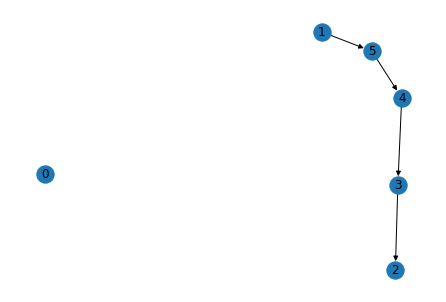

In [52]:
g = dgl.DGLGraph()
g.add_nodes(10)
# A couple edges one-by-one
for i in range(1, 4):
    g.add_edge(i, 0)
# A few more with a paired list
src = list(range(5, 8)); dst = [0]*3
g.add_edges(src, dst)
# finish with a pair of tensors
src = th.tensor([8, 9]); dst = th.tensor([0, 0])
g.add_edges(src, dst)

# Edge broadcasting will do star graph in one go!
g.clear(); g.add_nodes(10)
src = th.tensor(list(range(1, 10)));
g.add_edges(src, 0)

# Visualize the graph.
# nx.draw(g.to_networkx(), with_labels=True)
nx.draw(star1.to_networkx(), with_labels=True)
plt.show()